# Time Series Forecasting with RNNs, LSTMs, and CNNs

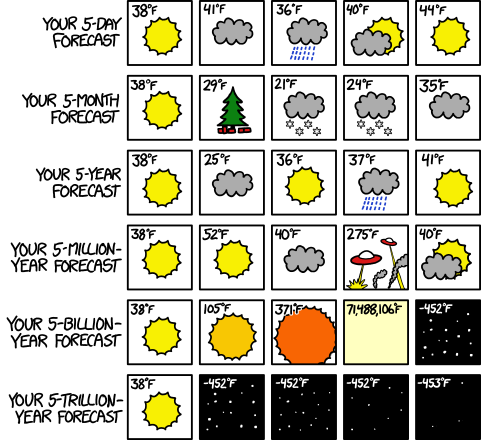

In [1]:
from IPython.display import Image
Image('https://imgs.xkcd.com/comics/five_day_forecast.png')

Image credit: xkcd https://creativecommons.org/licenses/by-nc/2.5/

This material is adapted from [Aurelien Geron's Udacity Time Series Forecasting Course](https://classroom.udacity.com/courses/ud187/lessons/6d543d5c-6b18-4ecf-9f0f-3fd034acd2cc/concepts/30611247-0a51-4748-bed0-f4e532fe1247) . <br>

Issues and questions
* verbose output is switching training and validation loss and mae.
* prediction on the validation set is sometimes much different than the last printed value of val_mae
* why do all the RNNs have a final lambda layer that scales outputs to the data range? This is just to help speed up convergence
* why is the `reset_states` callback used with the `stateful` RNN and the LSTM model, but not with the LSTM model that uses a CNN to preprocess the inputs?
* Note: see Kutay Kutlu's Kaggle kernel for sunspot forecasting [Time Series-TensorFlow RNN-LSTM Introduction](https://www.kaggle.com/kutaykutlu/time-series-tensorflow-rnn-lstm-introduction/notebook).

Reference: [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow 2nd ed.](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646), Ch 15, Aurelien Geron

Copyright 2018 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 1. Trend, Seasonality, and Noise in Time Series Data
Let's start by examining some characteristics common to time series data. A *trend* is a linear increase or decrease in data with time. For example if your salary is constant, your year-to-date earnings increase linearly from January to December. *Seasonality* refers to systematic yearly variation of data, for example increasing use of air conditioners during the hot months every year. *Noise refers* to the intrinsic day-to-day variability that is always present in time series data. In this section, we'll create a synthetic time series with trend, seasonality and noise which will serve as our data set for demonstrating time series forecasting! 

## Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

## Trend and Seasonality

In [5]:
def trend(time, slope=0):
    return slope * time

Let's create a time series that just trends upward:

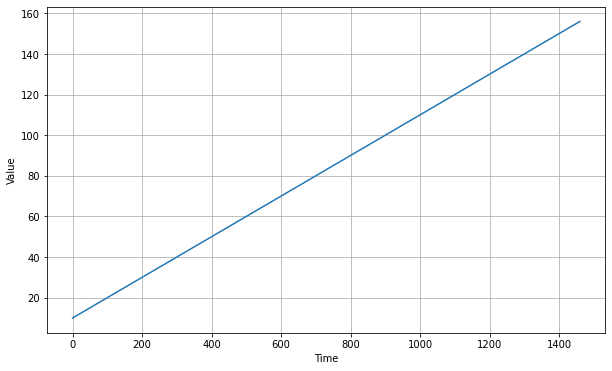

In [6]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [7]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [8]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

Now let's generate a time series with a seasonal pattern:

In [9]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

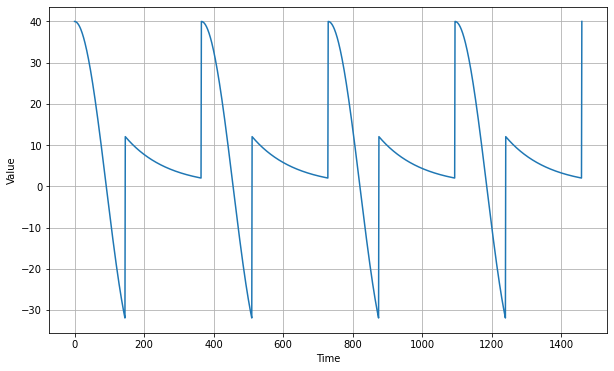

In [10]:
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's create a time series with both trend and seasonality:

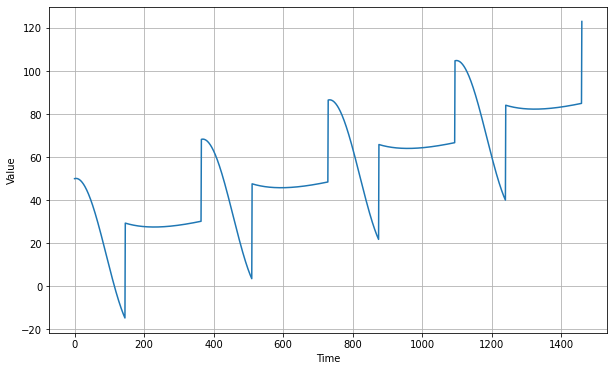

In [11]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Noise

In practice, few real-life time series have such a smooth signal. They usually have some noise, i.e. random measurement-to-measurement variation Let's generate some white additive Gaussian noise:

In [12]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

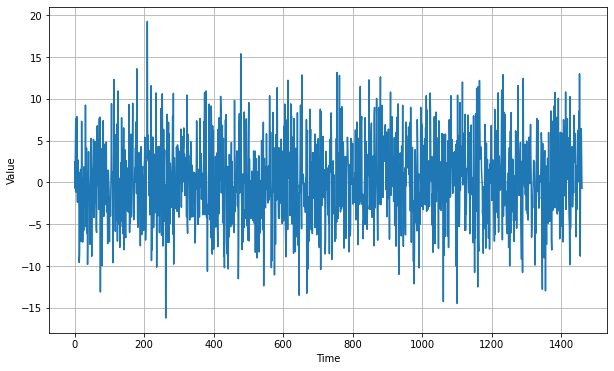

In [13]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Now let's add this white noise to create our example of a time series with trend seasonality and noise,

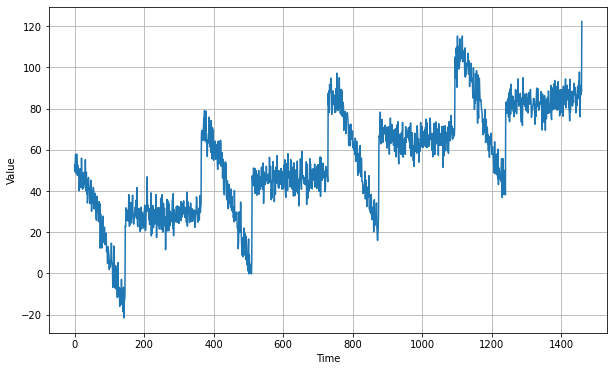

In [14]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# 2. Naive forecasting

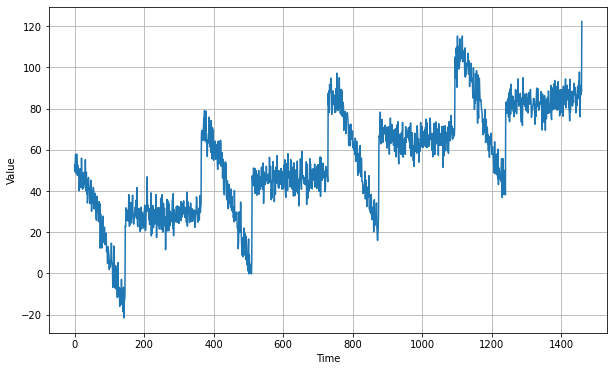

In [15]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000.

In [16]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Naive Forecast
For our naive forecast, for each day, we predict the signal to be the same as the previous day.

In [17]:
naive_forecast = series[split_time - 1:-1]

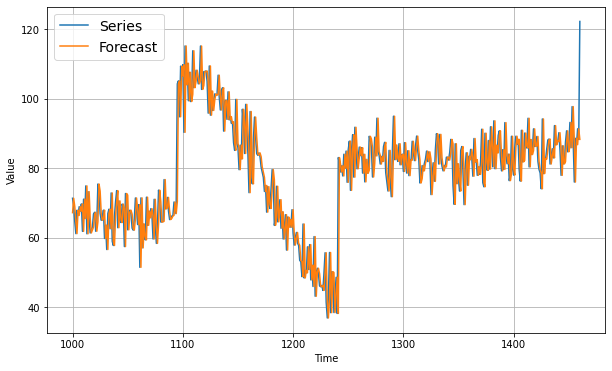

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

Though the fit appears pretty good, we see the problem when we
zoom in on the start of the validation period:

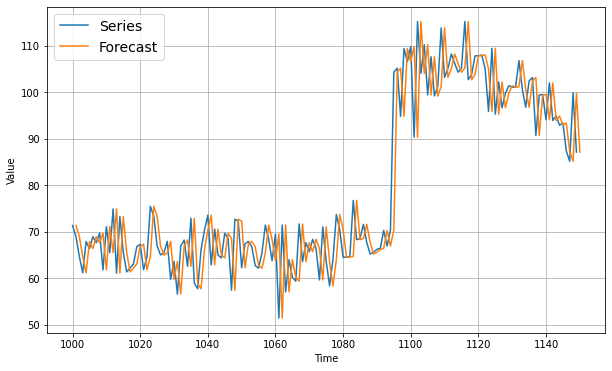

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean absolute error between the forecasts and the predictions in the validation period:

In [20]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
print(f'baseline (naive forecast): mae = {mae:.3f}')

baseline (naive forecast): mae = 5.938


That's our baseline, now let's try a moving average.

# 3. Moving average Forecast

## Moving Average
A *moving average* is the mean of the values in a "look-back window" of a specified length. <br>
A moving average forecast predicts the next day's data point as the moving average of the data in the "look-back" window.

In [21]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

Same computation, but much faster:

In [22]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

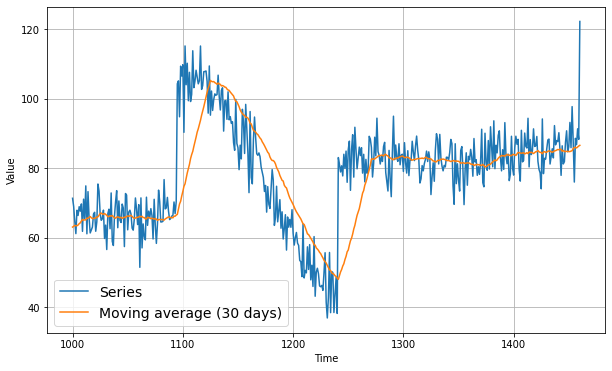

In [23]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [24]:
import tensorflow as tf
keras = tf.keras
mae = keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
print(f'moving average forecast: mae = {mae:.3f}')

moving average forecast: mae = 7.142


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

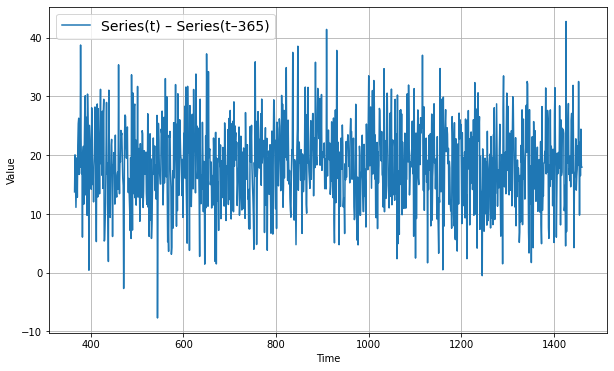

In [25]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

Focusing on the validation period:

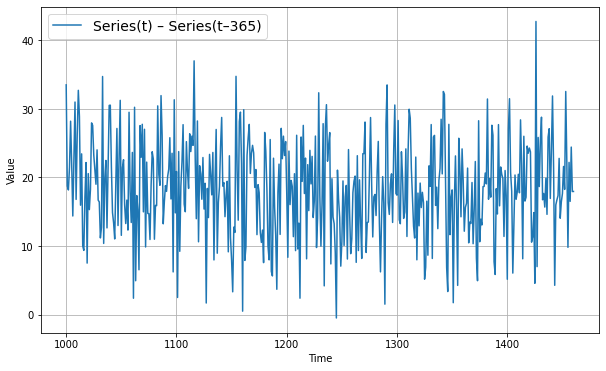

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

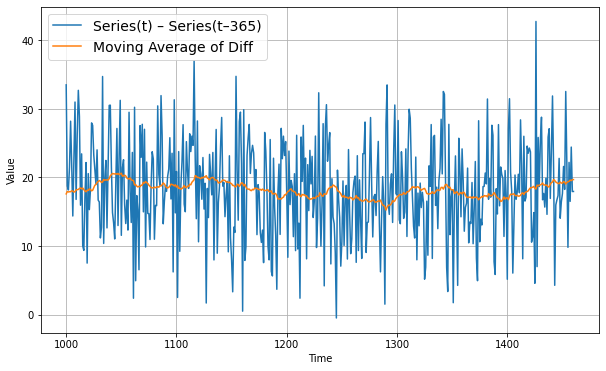

In [27]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

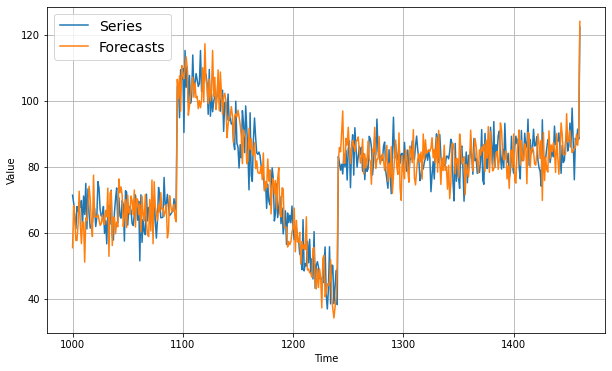

In [28]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [29]:
mae = keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()
print(f'moving average forecast with trend removed by differencing: mae = {mae:.3f}')

moving average forecast with trend removed by differencing: mae = 5.839


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

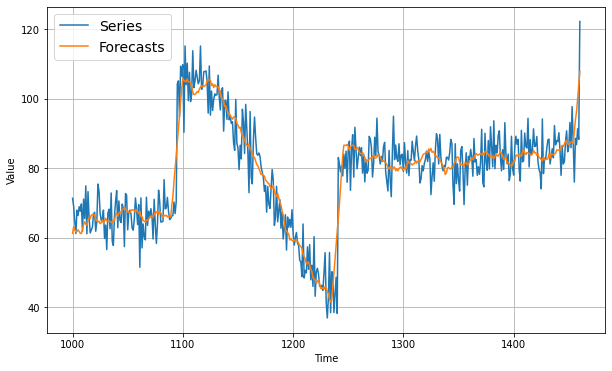

In [30]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [31]:
mae = keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()
print(f'smoothed moving average forecast with trend removed by differencing: mae = {mae:.3f}')

smoothed moving average forecast with trend removed by differencing: mae = 4.567


That's starting to look pretty good! Let's see if we can do better with a Machine Learning model.

# 4. Time windows
How to create windowed data sets in `tensorflow`

Our goal is to train a model to forecast the next step in a time series, given the data in a window<br>
Before building our machine learning model, we'll need shape our original timeseries into the proper input format. <br>
From the original time series we'll create a dataset composed of data windows
and their corresponding targets <br>that we want to predict. Note that the target can be the next data point after the window, or a set of consecutive data points after the window. <br>Let's see how `tensorflow` can help us accomplish this necessary preprocessing step.

We first create a `tensorflow` `RangeDataset` object

In [32]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


The `.window` method creates a data set of windows, a `WindowDataset` object

In [33]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


We can eliminate the incomplete windows as the end by specifying `drop_remainder=True`

In [34]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


We extract the individual windows with `.flat_map()`

In [35]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


We split the windows into data/target sequences

In [36]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


Use the `.shuffle` method to randomize the order of the sequences

In [37]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[3 4 5 6] [7]
[1 2 3 4] [5]
[2 3 4 5] [6]
[4 5 6 7] [8]
[0 1 2 3] [4]
[5 6 7 8] [9]


Generate batches of sequences using the `.batch()` method.<br>
The `.prefetch()` method generates a batch in parallel with the processing so it will be ready for processing at the next step.

In [38]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print("x =", x.numpy())
    print("y =", y.numpy())

x = [[2 3 4 5]
 [5 6 7 8]]
y = [[6]
 [9]]
x = [[4 5 6 7]
 [3 4 5 6]]
y = [[8]
 [7]]
x = [[1 2 3 4]
 [0 1 2 3]]
y = [[5]
 [4]]


Let's package up the machinery to prepare our data set into a helper function:

In [39]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# 5. Forecasting with machine learning

First, we will train a model to forecast the next step given the previous 30 steps. <br>
Let's prepare our training and validation data for modeling by creating datasets of 30-step windows.

In [42]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)


In [41]:
type(train_set)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

### 5.1 Linear Model Forecasting
First we'll try a linear model

In [43]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 3s 12ms/step - loss: 59.5352 - mae: 60.0347 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 44.0735 - mae: 44.5728 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 26.2740 - mae: 26.7727 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 11.1306 - mae: 11.6214 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 8.1097 - mae: 8.5977 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 8.0270 - mae: 8.5141 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 7.9629 - mae: 8.4476 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 7.9018 - mae: 8.3887 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 7.8362 - mae: 8.3210 - lr: 1.8

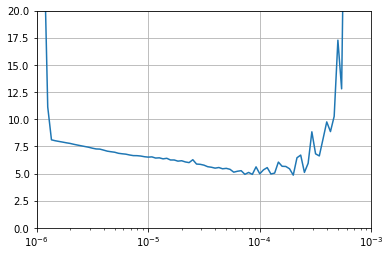

In [44]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])
plt.grid()

In [46]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] -

Let's create a helper function to produce a forecast, given a model and a data set.

In [47]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    # note we left out the shuffle() step, preserving the order in our batches
    #      but there is no reason not to include the shuffle() step
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [48]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [49]:
lin_forecast.shape

(461,)

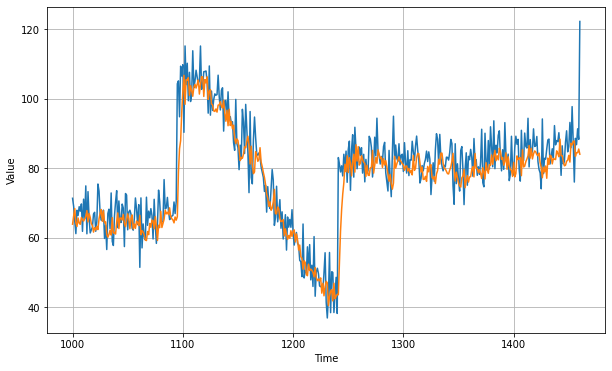

In [50]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [51]:
mae = keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()
print(f'linear model forecast: mae = {mae:.3f}')

linear model forecast: mae = 5.166


### 5.2 Dense Model Forecasting
Dense model with two hidden layers

In [52]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_layer_nodes = [32, 16]
model = keras.models.Sequential([
  keras.layers.Dense(n_layer_nodes[0], activation="relu", input_shape=[window_size]),
  keras.layers.Dense(n_layer_nodes[1], activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 44.4726 - mae: 44.9719 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 41.6296 - mae: 42.1284 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 38.2832 - mae: 38.7819 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 34.7155 - mae: 35.2134 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 31.0155 - mae: 31.5141 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 27.3342 - mae: 27.8309 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 23.7629 - mae: 24.2589 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 20.3416 - mae: 20.8353 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 17.2002 - mae: 17.6970 

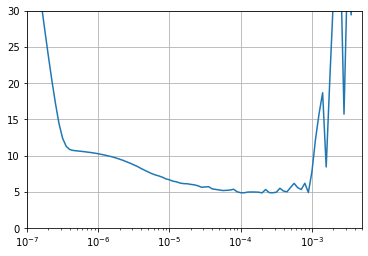

In [53]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])
plt.grid()

In [54]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(n_layer_nodes[0], activation="relu", input_shape=[window_size]),
  keras.layers.Dense(n_layer_nodes[1], activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                992       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
31/31 [==============================] - 1s 12ms/step - loss: 19.8962 - mae: 20.3903 - val_loss: 11.7562 - val_mae: 12.2496
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 10.0324 - mae: 10.5204 - val_loss: 8.9687 - val_mae: 9.4546
Epoch 3/500
31/31 [==============================

In [55]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

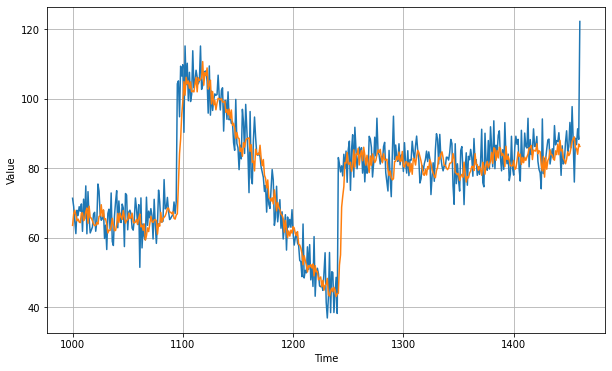

In [56]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [57]:
mae = keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()
print(f'dense model forecast: mae = {mae:.3f}')

dense model forecast: mae = 4.909


# 6. Forecasting with an RNN

## 6.1 Simple RNN Forecasting
Final Dense layer at the end takes only a single input<br>
This is a Sequence to Vector model

In [58]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

# scale_factor scales output of RNN by range
#     unnecessary if you normalize the data first
scale_factor = 200


# why is tf.expand_dims() used in the Lambda() layer
# why use a Dense layer at the end, instead of another SimpleRNN layer -- see Geron p 507
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * scale_factor)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 52ms/step - loss: 76.9372 - mae: 77.4368 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 49ms/step - loss: 32.1975 - mae: 32.6928 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 1s 48ms/step - loss: 32.4587 - mae: 32.9545 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 1s 47ms/step - loss: 24.9415 - mae: 25.4352 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 1s 46ms/step - loss: 22.9586 - mae: 23.4500 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 44ms/step - loss: 21.3527 - mae: 21.8431 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 1s 47ms/step - loss: 19.4278 - mae: 19.9200 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 1s 48ms/step - loss: 17.8326 - mae: 18.3242 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 1s 50ms/step - loss: 16.8136 - mae: 17.3035 - lr: 2.5

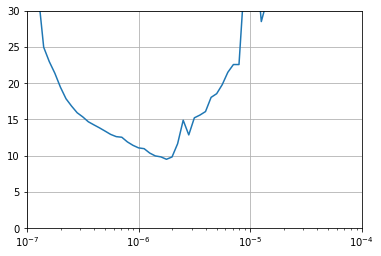

In [59]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])
plt.grid()

In [60]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * scale_factor)
])
optimizer = keras.optimizers.SGD(learning_rate=5.e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 2s 48ms/step - loss: 78.9207 - mae: 79.4183INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 4s 450ms/step - loss: 74.6885 - mae: 75.1859 - val_loss: 68.2003 - val_mae: 68.7003
Epoch 2/500
8/8 [==============================] - 3s 367ms/step - loss: 44.7915 - mae: 45.2897 - val_loss: 33.3464 - val_mae: 33.8457
Epoch 3/500
8/8 [==============================] - 3s 414ms/step - loss: 28.4245 - mae: 28.9217 - val_loss: 29.7775 - val_mae: 30.2755
Epoch 4/500
8/8 [==============================] - 3s 370ms/step - loss: 20.7410 - mae: 21.2347 - val_loss: 17.2456 - val_mae: 17.7402
Epoch 5/500
8/8 [==============================] - 1s 64ms/step - loss: 18.3190 - mae: 18.8141 - val_loss: 22.3688 - val_mae: 22.8653
Epoch 6/500
8/8 [==============================] - 3s 376ms/step - loss: 16.7107 - mae: 17.1998 - val_loss: 15.9664 - val_mae: 16.4621
Epoch 7/500
8/8 [==============================] - 3s 407ms/step - loss: 1

In [61]:
model = keras.models.load_model("my_checkpoint")

In [62]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

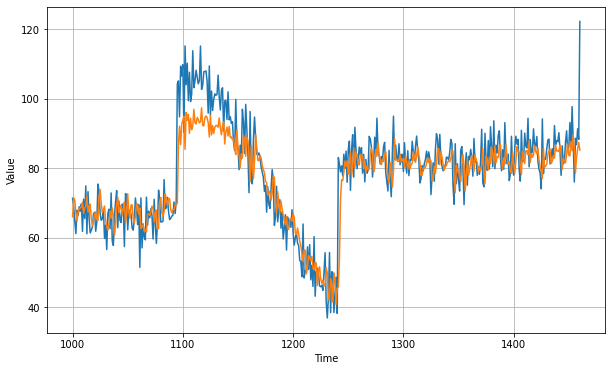

In [63]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [64]:
mae = keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
print(f'simpleRNN model forecast: mae = {mae:.3f}')

simpleRNN model forecast: mae = 5.646


## 6.2 Sequence-to-Sequence Forecasting
`SimpleRNN` with time-distributed Dense layer at the end; takes inputs at all time steps and predicts all the values in the next window.<br>
We need to modify our `window_dataset()` function to create the sequence-to-sequence (seq2seq) data set

In [65]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    # next line is not in window_dataset()
    series = tf.expand_dims(series, axis=-1) # this is the only extra line
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    # the target is the next window of time steps, not just the next time step
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


'''
for comparison:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    ds = dataset.flat_map(lambda w: w.batch(window_size + 1))
    ds = dataset.shuffle(shuffle_buffer)
    # the target is the next value after the window
    ds = dataset.map(lambda w: (w[:-1], w[-1]))
    ds = dataset.batch(batch_size).prefetch(1)
    return ds
'''

'\nfor comparison:\ndef window_dataset(series, window_size, batch_size=32,\n                   shuffle_buffer=1000):\n    ds = tf.data.Dataset.from_tensor_slices(series)\n    ds = dataset.window(window_size + 1, shift=1, drop_remainder=True)\n    ds = dataset.flat_map(lambda w: w.batch(window_size + 1))\n    ds = dataset.shuffle(shuffle_buffer)\n    # the target is the next value after the window\n    ds = dataset.map(lambda w: (w[:-1], w[-1]))\n    ds = dataset.batch(batch_size).prefetch(1)\n    return ds\n'

Here is how `seq_to_seq_window_dataset()` works

In [66]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [67]:
# !!!!! shouldn't Dense(1) be Dense(window_size)?????
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

scale_factor = 200
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)


model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * scale_factor)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 49ms/step - loss: 73.8068 - mae: 74.3065 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 45ms/step - loss: 32.9782 - mae: 33.4747 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 1s 49ms/step - loss: 33.7222 - mae: 34.2190 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 1s 51ms/step - loss: 26.5639 - mae: 27.0596 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 1s 51ms/step - loss: 26.0239 - mae: 26.5192 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 47ms/step - loss: 23.6359 - mae: 24.1299 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 1s 49ms/step - loss: 22.2794 - mae: 22.7731 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 1s 45ms/step - loss: 21.1343 - mae: 21.6269 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 1s 48ms/step - loss: 20.1876 - mae: 20.6794 - lr: 1.8

(1e-07, 0.0001, 0.0, 30.0)

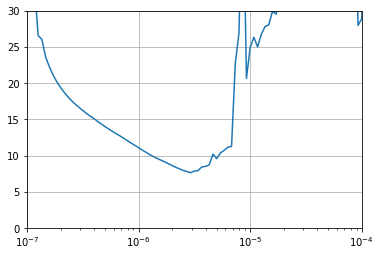

In [68]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.grid()
plt.axis([1e-7, 1e-4, 0, 30])

In [69]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)


model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * scale_factor)
])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 100)         10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 100)         20100     
                                                                 
 dense (Dense)               (None, None, 1)           101       
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
8/8 [==============================] - 2s 110ms/step - loss: 51.8148 - mae: 52.3130 - val_loss: 19.2710 - val_mae: 19.7651
Epoch 2/500
8/8 [==============================] 

In [70]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

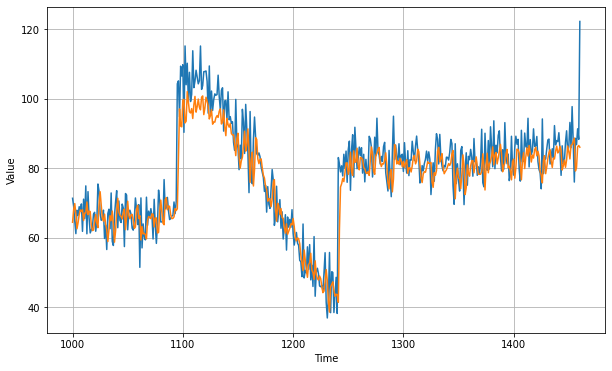

In [71]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [72]:
mae = keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
print(f'seq2seqRNN model forecast: mae = {mae:.3f}')

seq2seqRNN model forecast: mae = 5.375


# 6.3 Forecasting with a stateful sequence-to-sequence (seq2seq) RNN

In [73]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

###Stateful RNN Forecasting<br>
A stateful RNN passes the final hidden state vector from a batch into the initial state vector of the next batch, so that it continuously updates and improves the hidden state vector at every batch. The state vector is reset at the beginning of each epoch.  A stateful RNN can potentially remember information from the entire data sequence over an epoch.<br><br> 

In order to process the data this way, we need to format the data set in *sequential* batches.<br>
There is no `.shuffle()` step, as we want to keep the batches in order<br>
This requires the following modification to `seq2seq_window_dataset()`


In [74]:
# note that batch size = 1
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)


"""
for comparison
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    # next line is not in window_dataset()
    series = tf.expand_dims(series, axis=-1) # this is the only extra line
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    # the target is the series of next values not just the next value
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds
"""

'\nfor comparison\ndef seq2seq_window_dataset(series, window_size, batch_size=32,\n                           shuffle_buffer=1000):\n    # next line is not in window_dataset()\n    series = tf.expand_dims(series, axis=-1) # this is the only extra line\n    ds = tf.data.Dataset.from_tensor_slices(series)\n    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)\n    ds = ds.flat_map(lambda w: w.batch(window_size + 1))\n    ds = ds.shuffle(shuffle_buffer)\n    # the target is the series of next values not just the next value\n    ds = ds.map(lambda w: (w[:-1], w[1:]))\n    ds = ds.batch(batch_size).prefetch(1)\n    return ds\n'

Here is how `sequential_window_dataset()` works:

In [75]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


We introduce the `reset_states` callback here, <br>
to reset the states at the beginning of each epoch<br>

In [76]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [77]:
# !!!!! shouldn't Dense(1) be Dense(window_size)?????
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * scale_factor)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 2s 34ms/step - loss: 105.9340 - mae: 106.4339 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 34ms/step - loss: 70.8571 - mae: 71.3571 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 1s 33ms/step - loss: 39.8079 - mae: 40.3047 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 1s 34ms/step - loss: 27.3450 - mae: 27.8404 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 1s 32ms/step - loss: 24.4956 - mae: 24.9891 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 1s 33ms/step - loss: 23.2601 - mae: 23.7517 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 1s 34ms/step - loss: 22.0604 - mae: 22.5533 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 1s 33ms/step - loss: 20.8543 - mae: 21.3463 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 1s 33ms/step - loss: 19.8307 - ma

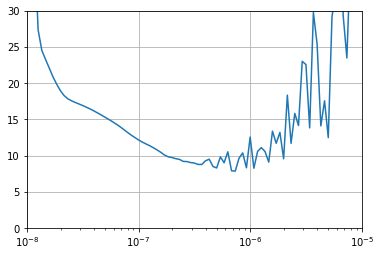

In [78]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-5, 0, 30])
plt.grid()

In [79]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * scale_factor)
])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=6e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50) # ????? why patience = 50
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (1, None, 100)            10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (1, None, 100)            20100     
                                                                 
 dense (Dense)               (1, None, 1)              101       
                                                                 
 lambda (Lambda)             (1, None, 1)              0         
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
33/33 [==============================] - 3s 48ms/step - loss: 69.1706 - mae: 69.6696 - val_loss: 38.7957 - val_mae: 39.2952
Epoch 2/500
33/33 [=============================

In [80]:
model = keras.models.load_model("my_checkpoint.h5")

In [81]:
model.reset_states()
# why does the predict method require the input in this format?
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis]) 
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [82]:
rnn_forecast.shape

(461,)

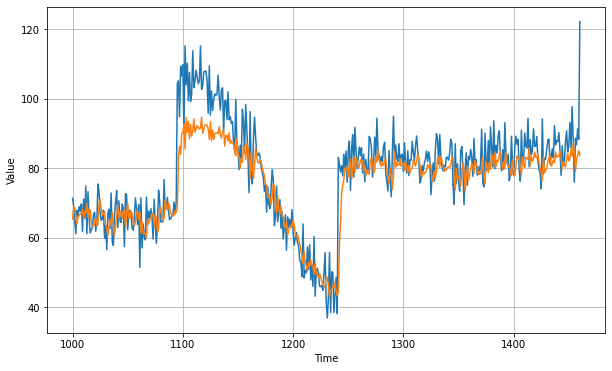

In [83]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [84]:
mae = keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
print(f'stateful seq2seqRNN model forecast: mae = {mae:.3f}')

stateful seq2seqRNN model forecast: mae = 5.817


# 7. Forecasting with an LSTM

The LSTM is a modified version of the RNN that can learn longer term patterns.<br>
LSTMs have two hidden states; one learns short term patterns and the other learns long term patterns. 

In [85]:
# !!!!! shouldn't Dense(1) be Dense(window_size)?????
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
lstm_size = 100
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(lstm_size, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(lstm_size, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 2 * 100)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 5s 8ms/step - loss: 90.9191 - mae: 91.4191 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 8ms/step - loss: 83.8978 - mae: 84.3978 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 75.4974 - mae: 75.9974 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 66.0676 - mae: 66.5676 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 8ms/step - loss: 55.5131 - mae: 56.0131 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 43.7599 - mae: 44.2597 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 30.7909 - mae: 31.2900 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 7ms/step - loss: 17.1478 - mae: 17.6436 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 7ms/step - loss: 10.0311 - mae: 10.5178 

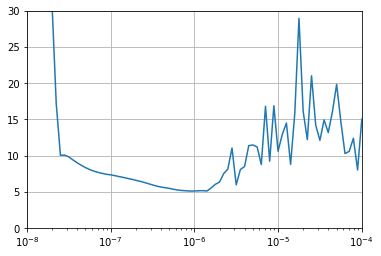

In [86]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.grid()

In [87]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
lstm_size = 100
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(lstm_size, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(lstm_size, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 2 * 100)
])

model.summary()
optimizer = keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, None, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (1, None, 100)            80400     
                                                                 
 dense (Dense)               (1, None, 1)              101       
                                                                 
 lambda (Lambda)             (1, None, 1)              0         
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
33/33 [==============================] - 3s 32ms/step - loss: 30.0122 - mae: 30.5051 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/500
33/33 [===========================

In [88]:
model = keras.models.load_model("my_checkpoint.h5")

In [89]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

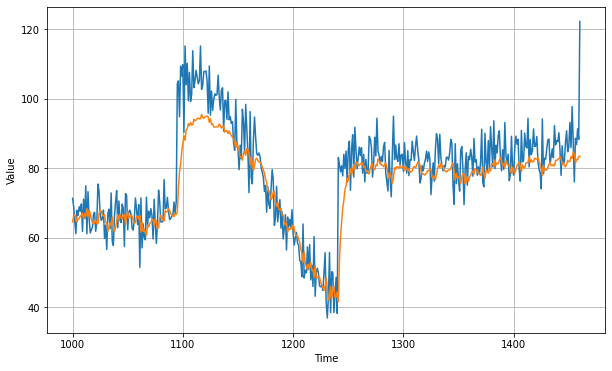

In [90]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [91]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.784192

# 8. Application of CNNs to time series forecasting
In this section we will consider architectures that include 1-dimensional Convolutional Neural Networks. <br>
First we'll build a hybrid network of a CNN followed by LSTMs, then we'll build a fully convolutional network.

## 8.1 Preprocessing With a 1D-Convolutional Layer followed by LSTM Layers

In [92]:
# !!!!! shouldn't Dense(1) be Dense(window_size)?????
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
lstm_size = 100
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(lstm_size, return_sequences=True),
  keras.layers.LSTM(lstm_size, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 2 * 100)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
     lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 10s 37ms/step - loss: 52.2866 - mae: 52.7860 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 47.8536 - mae: 48.3527 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 35.9895 - mae: 36.4867 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 26.7218 - mae: 27.2151 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 23.3853 - mae: 23.8778 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 22.3881 - mae: 22.8815 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 21.9342 - mae: 22.4277 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 21.4867 - mae: 21.9802 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 21.0560 - mae: 21.5487 - lr: 2.

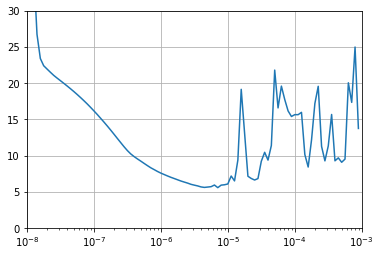

In [93]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 30])
plt.grid()

In [94]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
lstm_size = 100
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 2 * 100)
])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 lstm (LSTM)                 (None, None, 32)          8320      
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 dense (Dense)               (None, None, 1)           33        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
8/8 [==============================] - 4

In [95]:
model = keras.models.load_model("my_checkpoint.h5")

In [96]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

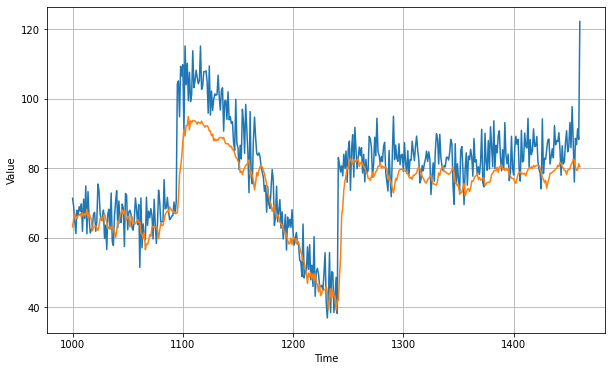

In [97]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [98]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.728522

## 8.2 Fully Convolutional Forecasting
We will use an architecture inpired by [WaveNet](https://deepmind.com/blog/article/wavenet-generative-model-raw-audio), which was created by DeepMind in the context of text-to-speech generation. <br>
We apply a series of 1-dimensional convolutional filters of increasing scale (dilation), enabling our model to learn patterns on different time scales that might be present in the input time series.

---



In [99]:
# !!!!! shouldn't Dense(1) be Dense(window_size)?????
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 35ms/step - loss: 42.2341 - mae: 42.7330 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 41.8293 - mae: 42.3284 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 41.4367 - mae: 41.9357 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 41.0108 - mae: 41.5098 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 40.4787 - mae: 40.9776 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 39.7341 - mae: 40.2328 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 38.5883 - mae: 39.0871 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 36.6836 - mae: 37.1822 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 33.3644 - mae: 33.8628 - lr: 1.8478e-

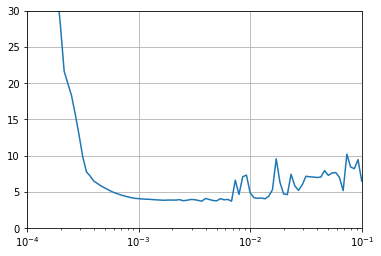

In [100]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])
plt.grid()

In [101]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
model.summary()
optimizer = keras.optimizers.Adam(learning_rate=1.e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 1)           3

In [102]:
model = keras.models.load_model("my_checkpoint.h5")

In [103]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

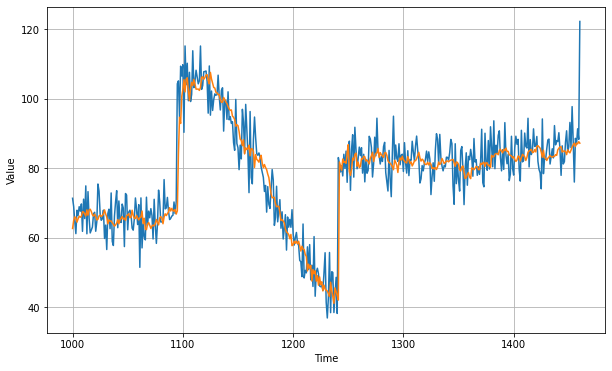

In [104]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [105]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.583659